# Configuration

In [1]:
import trappy
import numpy

config = {}

# TRAPpy Events
config["THERMAL"] = trappy.thermal.Thermal
config["OUT"] = trappy.cpu_power.CpuOutPower
config["IN"] = trappy.cpu_power.CpuInPower
config["PID"] = trappy.pid_controller.PIDController
config["GOVERNOR"] = trappy.thermal.ThermalGovernor

# Control Temperature
config["CONTROL_TEMP"] = 77000

# A temperature margin of 2.5 degrees Celsius
config["TEMP_MARGIN"] = 2500

# The Sustainable power at the control Temperature
config["SUSTAINABLE_POWER"] = 2500

# Expected percentile of CONTROL_TEMP + TEMP_MARGIN
config["EXPECTED_TEMP_QRT"] = 95

# Maximum expected Standard Deviation as a percentage
# of mean temperature
config["EXPECTED_STD_PCT"] = 5


# Get the Trace

In [2]:
import urllib
import os

TRACE_DIR = "example_trace_dat_thermal"
TRACE_FILE = os.path.join(TRACE_DIR, 'bart_thermal_trace.dat')
TRACE_URL = 'http://cdn.rawgit.com/sinkap/4e0a69cbff732b57e36f/raw/7dd0ed74bfc17a34a3bd5ea6b9eb3a75a42ddbae/bart_thermal_trace.dat'

if not os.path.isdir(TRACE_DIR):
    os.mkdir(TRACE_DIR)

if not os.path.isfile(TRACE_FILE):
    print "Fetching trace file.."
    urllib.urlretrieve(TRACE_URL, filename=TRACE_FILE)

# FTrace Object

In [3]:
# Create a Trace object

ftrace = trappy.FTrace(TRACE_FILE, "SomeBenchMark")

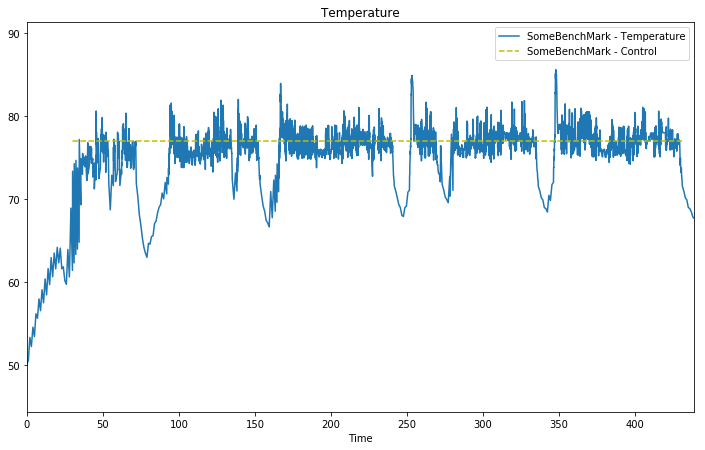

In [41]:
import trappy.plot_utils

trappy.plot_utils.plot_temperature([ftrace])

In [12]:
trappy.ILinePlot(
    ftrace,
    signals=["thermal:temp"],
).view()

""
""


# Assertions

In [4]:
# Create an Assertion Object

from bart.common.Analyzer import Analyzer
t = Analyzer(ftrace, config)

BIG = '000000f0'
LITTLE = '0000000f'

## Assertion: Load and Dynamic Power

<html>
This assertion makes sure that the dynamic power for the each cluster is zero when the sum of the "loads" of each CPU is 0

    $$\forall\ t\ |\ Load(t) = \sum\limits_{i=0}^{cpus} Load_i(t) = 0 \implies dynamic\ power(t)=0 $$
    
</html>

In [5]:
result = t.getStatement("((IN:load0 + IN:load1 + IN:load2 + IN:load3) == 0) \
                & (IN:dynamic_power > 0)",reference=True, select=BIG)
if len(result):
    print "FAIL: Dynamic Power is NOT Zero when load is Zero for the BIG cluster"
else:
    print "PASS: Dynamic Power is Zero when load is Zero for the BIG cluster"

    
result = t.getStatement("((IN:load0 + IN:load1 + IN:load2 + IN:load3) == 0) \
                & (IN:dynamic_power > 0)",reference=True, select=LITTLE)
if len(result):
    print "FAIL: Dynamic Power is NOT Zero when load is Zero for the LITTLE cluster"
else:
    print "PASS: Dynamic Power is Zero when load is Zero for the LITTLE cluster"

PASS: Dynamic Power is Zero when load is Zero for the BIG cluster
PASS: Dynamic Power is Zero when load is Zero for the LITTLE cluster


## Assertion: Control Temperature and Sustainable Power

<html>

When the temperature is greater than the control temperature, the total power granted to all cooling devices should be less than sustainable_power

$$\forall\ t\ |\ Temperature(t) > control\_temp \implies Total\ Granted\ Power(t) < sustainable\_power$$

<html/>

In [6]:
result = t.getStatement("(GOVERNOR:current_temperature > CONTROL_TEMP) &\
            (PID:output > SUSTAINABLE_POWER)", reference=True, select=0)

if len(result):
    print "FAIL: The Governor is allocating power > sustainable when T > CONTROL_TEMP"
else:
    print "PASS: The Governor is allocating power <= sustainable when T > CONTROL_TEMP"    

FAIL: The Governor is allocating power > sustainable when T > CONTROL_TEMP


# Statistics

Check if 95% of the temperature readings are below CONTROL_TEMP + MARGIN

In [7]:
t.assertStatement("numpy.percentile(THERMAL:temp, 95) < (CONTROL_TEMP + TEMP_MARGIN)")

True

Check if the mean temperauture is less than CONTROL_TEMP

In [8]:
t.assertStatement("numpy.mean(THERMAL:temp) <= CONTROL_TEMP",  select=0)

True

We can also use getStatement to get the absolute values. Here we are getting the standard deviation expressed as a percentage of the mean

In [9]:
t.getStatement("(numpy.std(THERMAL:temp) * 100.0) / numpy.mean(THERMAL:temp)", select=0)

2.5986602052011483

# Thermal Residency

In [10]:
from bart.thermal.ThermalAssert import ThermalAssert

t_assert = ThermalAssert(ftrace)
end = ftrace.get_duration()

LOW = 0
HIGH = 78000

# The thermal residency gives the percentage (or absolute time) spent in the
# specified temperature range. 

result = t_assert.getThermalResidency(temp_range=(0, 78000),
                                              window=(0, end),
                                              percent=True)

for tz_id in result:
    print "Thermal Zone: {} spends {:.2f}% time in the temperature range [{}, {}]".format(tz_id, 
                                                                                          result[tz_id],
                                                                                          LOW/1000,
                                                                                          HIGH/1000)
    pct_temp = numpy.percentile(t.getStatement("THERMAL:temp")[tz_id], result[tz_id])
    
    print "The {:.2f}th percentile temperature is {:.2f}".format(result[tz_id], pct_temp / 1000.0)
    

Thermal Zone: 0 spends 86.58% time in the temperature range [0, 78]
The 86.58th percentile temperature is 78.27
